In [1]:
# Check Pytorch installation
import torch, torchvision
print("torch version:",torch.__version__, "cuda:",torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print("mmdetection:",mmdet.__version__)

# Check mmcv installation
import mmcv
print("mmcv:",mmcv.__version__)

# Check mmengine installation
import mmengine
print("mmengine:",mmengine.__version__)

torch version: 2.4.1+cu124 cuda: True
mmdetection: 3.3.0
mmcv: 2.2.0
mmengine: 0.10.5


In [2]:
!mim download mmdet --config mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco --dest ./checkpoints

processing mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco...
mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth exists in /home/muyishen2040/mmdetection/mmdet_pipeline/checkpoints
Successfully dumped mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py to /home/muyishen2040/mmdetection/mmdet_pipeline/checkpoints


In [4]:
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
# Choose to use a config and initialize the detector
config_file = '../configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py'
# Setup a checkpoint file to load
checkpoint_file = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# register all modules in mmdet into the registries
register_all_modules()

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or device='cuda:0'

Loads checkpoint by local backend from path: checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


/home/muyishen2040/develop_env/lib/python3.10/site-packages/mmengine/runner/checkpoint.py:347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename

In [5]:
image = mmcv.imread('../demo/demo.jpg',channel_order='rgb')
result = inference_detector(model, image)
print(result)

<DetDataSample(

    META INFORMATION
    batch_input_shape: (800, 1216)
    scale_factor: (1.8734375, 1.873536299765808)
    img_id: 0
    img_path: None
    ori_shape: (427, 640)
    img_shape: (800, 1199)
    pad_shape: (800, 1216)

    DATA FIELDS
    gt_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            masks: BitmapMasks(num_masks=0, height=427, width=640)
            labels: tensor([], device='cuda:0', dtype=torch.int64)
            bboxes: tensor([], device='cuda:0', size=(0, 4))
        ) at 0x7a514d105cf0>
    ignored_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            masks: BitmapMasks(num_masks=0, height=427, width=640)
            labels: tensor([], device='cuda:0', dtype=torch.int64)
            bboxes: tensor([], device='cuda:0', size=(0, 4))
        ) at 0x7a514d105c30>
    pred_instances: <InstanceData(
        
            META INFORMATION
        
     

In [6]:
from mmdet.registry import VISUALIZERS
# init visualizer(run the block only once in jupyter notebook)
visualizer = VISUALIZERS.build(model.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = model.dataset_meta

/home/muyishen2040/develop_env/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


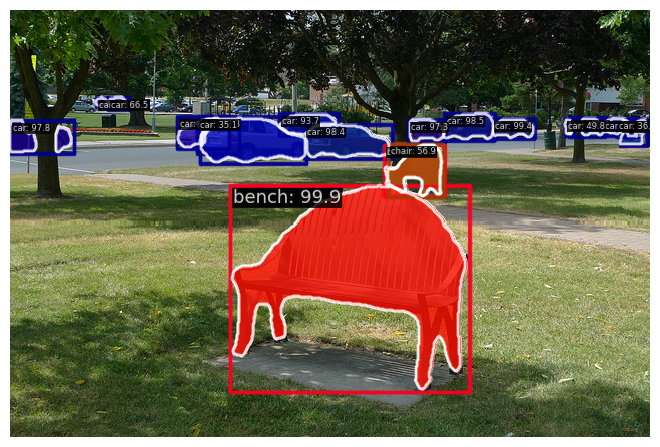

In [7]:
# show the results
visualizer.add_datasample(
    'result',
    image,
    data_sample=result,
    draw_gt = None,
    wait_time=0,
)
visualizer.show()

loading annotations into memory...
Done (t=0.54s)
creating index...
index created!
{0: 'tooth', 1: 'bone_level_area', 2: 'cej_level'}


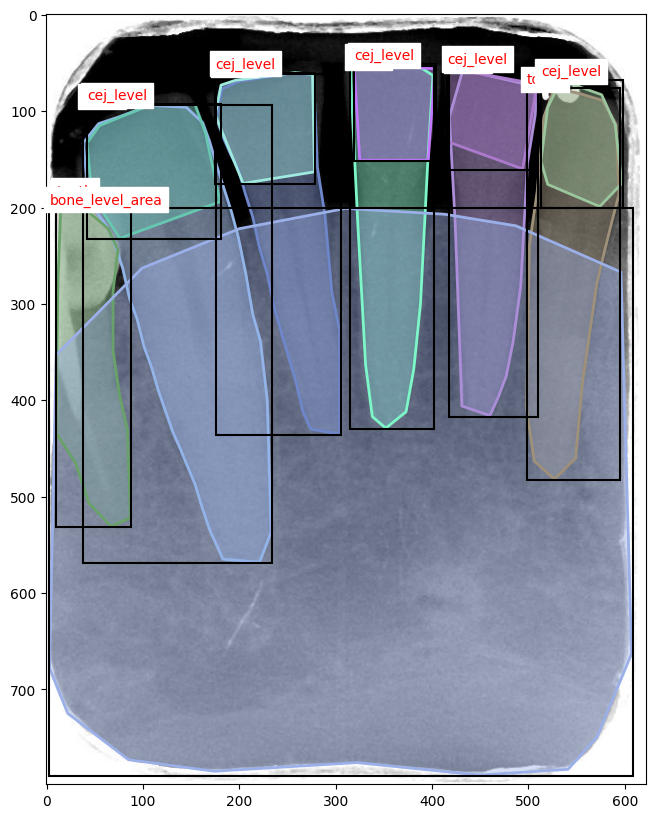

In [26]:
import os
import random
import json
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from matplotlib.patches import Polygon
import cv2

data_dir = '/home/muyishen2040/taipei_medical/tmu_coco'
image_dir = data_dir
annotation_file = os.path.join(data_dir, 'annotations.json')

coco = COCO(annotation_file)

def visualize_image_with_annotations(coco, image_dir, image_id, show_bbox=True):
    img_info = coco.loadImgs(image_id)[0]
    img_path = os.path.join(image_dir, img_info['file_name'])
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    coco.showAnns(anns)

    category_names = {cat['id']: cat['name'] for cat in coco.loadCats(coco.getCatIds())}
    
    print(category_names)

    if show_bbox:
        for ann in anns:
            bbox = ann['bbox']
            x, y, width, height = bbox
            category_id = ann['category_id']
            category_name = category_names[category_id]

            rect = plt.Rectangle((x, y), width, height, linewidth=1.5, edgecolor='black', facecolor='none')
            plt.gca().add_patch(rect)

            plt.text(x, y - 5, category_name, color='red', fontsize=10, backgroundcolor='white')

    plt.show()
    
image_ids = coco.getImgIds()
random_image_id = random.choice(image_ids)
visualize_image_with_annotations(coco, image_dir, random_image_id, show_bbox=True)


In [19]:
import json
import random
import os

def split_coco_dataset(annotation_file, output_dir, train_ratio=0.8):
    with open(annotation_file, 'r') as f:
        coco_data = json.load(f)
    
    images = coco_data['images']
    annotations = coco_data['annotations']
    
    random.shuffle(images)
    
    split_idx = int(train_ratio * len(images))
    train_images = images[:split_idx]
    val_images = images[split_idx:]
    
    train_img_ids = {img['id'] for img in train_images}
    val_img_ids = {img['id'] for img in val_images}
    
    train_annotations = [ann for ann in annotations if ann['image_id'] in train_img_ids]
    val_annotations = [ann for ann in annotations if ann['image_id'] in val_img_ids]
    
    train_data = {k: coco_data[k] for k in coco_data if k != 'images' and k != 'annotations'}
    val_data = {k: coco_data[k] for k in coco_data if k != 'images' and k != 'annotations'}
    train_data['images'] = train_images
    train_data['annotations'] = train_annotations
    val_data['images'] = val_images
    val_data['annotations'] = val_annotations

    with open(os.path.join(output_dir, 'train_annotations.json'), 'w') as f:
        json.dump(train_data, f)
    
    with open(os.path.join(output_dir, 'val_annotations.json'), 'w') as f:
        json.dump(val_data, f)
    
    print(f"Train and validation sets created and saved to {output_dir}.")

data_dir = '/home/muyishen2040/taipei_medical/tmu_coco'
image_dir = data_dir
annotation_file = os.path.join(data_dir, 'annotations.json')

split_coco_dataset(
    annotation_file=annotation_file,
    output_dir=data_dir,
    train_ratio=0.8
)


Train and validation sets created and saved to /home/muyishen2040/taipei_medical/tmu_coco.


In [20]:
import json
import os

def verify_coco_split(annotation_file):
    with open(annotation_file, 'r') as f:
        data = json.load(f)
    
    num_images = len(data['images'])
    num_annotations = len(data['annotations'])
    
    print(f"File: {annotation_file}")
    print(f"Number of images: {num_images}")
    print(f"Number of annotations: {num_annotations}")
    print("-" * 30)

# Paths to the generated JSON files
train_json = '/home/muyishen2040/taipei_medical/tmu_coco/train_annotations.json'
val_json = '/home/muyishen2040/taipei_medical/tmu_coco/val_annotations.json'

# Verify train and validation datasets
verify_coco_split(train_json)
verify_coco_split(val_json)

# Optionally, verify the original file
original_json = '/home/muyishen2040/taipei_medical/tmu_coco/annotations.json'
verify_coco_split(original_json)


File: /home/muyishen2040/taipei_medical/tmu_coco/train_annotations.json
Number of images: 7180
Number of annotations: 55789
------------------------------
File: /home/muyishen2040/taipei_medical/tmu_coco/val_annotations.json
Number of images: 1796
Number of annotations: 13924
------------------------------
File: /home/muyishen2040/taipei_medical/tmu_coco/annotations.json
Number of images: 8976
Number of annotations: 69713
------------------------------
